In [0]:
#import all the packages
import numpy as np
import pandas as pd
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
!pip install emoji
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.externals import joblib 
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from statistics import mean
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.layers import Embedding
from keras.layers.core import SpatialDropout1D
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Activation, Flatten

     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=2df049c337e26b0a74d8d434eef6d1cf1d5e29ef1caece98296f74099c3c986e
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.layers import MaxPooling1D

Using TensorFlow backend.


In [0]:
import keras
from keras import backend as b
import tensorflow as tf

# Define our own loss function
def loss(y_true, y_pred):
    g = 2.0
    a = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -b.sum(a * b.pow(1. - pt_1, g) * b.log(pt_1))-b.sum((1-a) * b.pow( pt_0, g) * b.log(1. - pt_0))


In [0]:
# Define a function to load embedding into memory

def embedding(filename):

    f = open(filename,'r')
    lines = f.readlines()
    f.close()

    emb = dict()
    for line in lines:
        parts = line.split()
        
        emb[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return emb

In [0]:
# define weight matrix dimensions 
def weight_matrix(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 300))

    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

In [0]:
#load dataset train set
df_train=pd.read_csv("/content/drive/My Drive/AIt/trainset (1).csv")

In [0]:
#load test set
df_test=pd.read_csv("/content/drive/My Drive/AIt/testset (1).csv")

In [0]:
#drop unnamed column
df_train.drop(df_train.columns[df_train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [0]:
#drop unnamed column
df_test.drop(df_test.columns[df_test.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [0]:
#Take job data in x and fraudulent in y and check the shape
X_train=df_train['job_data'].values
X_test=df_test['job_data'].values
Y_train=df_train['fraudulent']
Y_test=df_test['fraudulent']
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(25676,) (25676,)
(3576,) (3576,)


In [0]:
#check unique values in y_train
Y_train.unique()

array([1, 0])

In [0]:
#do one hot encoding for y_train
Ytrain = pd.get_dummies(Y_train).values
Ytrain

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [0]:
Y_test

0       0
1       0
2       0
3       0
4       1
       ..
3571    0
3572    0
3573    0
3574    0
3575    0
Name: fraudulent, Length: 3576, dtype: int64

In [0]:
#do one hot encoding for y_test
Ytest = pd.get_dummies(Y_test).values
Ytest

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [0]:
# every word is assigned a unique number in the train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [0]:
#the unique values are replaced in the train set
encoding_layer = tokenizer.texts_to_sequences(X_train)

In [0]:
#identify longest sequence of words in document and do padding for remaining sequences if needed
Xtrain = pad_sequences(encoding_layer, maxlen=3432, padding='post')

In [0]:
#finds length of tokens in a document
document_size = len(tokenizer.word_index) + 1

In [0]:
#load the golve 300 to a new variable using the function defined
glove_d = embedding('/content/drive/My Drive/AIt/glove.6B.300d.txt')

In [0]:
#load the weights of the words to a new variable
embed_vect = weight_matrix(glove_d, tokenizer.word_index)
#changing the words in the tokens to 300d vector
embed_layer = Embedding(document_size, 300, weights=[embed_vect], input_length=3432, trainable=False)

In [0]:
#using sequential 2 layer model with certain parameters
cnn = Sequential()
cnn.add(embed_layer)

cnn.add(Conv1D(100, 2, activation='relu'))

cnn.add(MaxPooling1D(2))
cnn.add(Conv1D(200, 2, activation='relu'))



cnn.add(MaxPooling1D(2))

cnn.add(SpatialDropout1D(0.2))

cnn.add(Flatten())
cnn.add(Dense(2, activation='sigmoid'))
cnn.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])


In [0]:
#the final epochs value is 3 and batch size is 64
epochs = 3

batch_size = 64

fit = cnn.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_split=0.1)




Train on 23108 samples, validate on 2568 samples
Epoch 1/3
23108/23108 [==============================] - 836s 36ms/step - loss: 0.1625 - accuracy: 0.9311 - val_loss: 0.0244 - val_accuracy: 0.9920
Epoch 2/3
23108/23108 [==============================] - 832s 36ms/step - loss: 0.0135 - accuracy: 0.9972 - val_loss: 0.0209 - val_accuracy: 0.9936
Epoch 3/3
23108/23108 [==============================] - 836s 36ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0108 - val_accuracy: 0.9975


In [0]:
# every word is assigned a unique number in the test data
encod_layer_test = tokenizer.texts_to_sequences(X_test)

In [0]:
#the unique values are replaced in the test set
Xtest = pad_sequences(encod_layer_test, maxlen=3432, padding='post')

In [0]:
#evaluate model on test set and calculate accuracy
loss, accuracy = cnn.evaluate(Xtest, Ytest, verbose=0)
print('Accuracy of the model: %f' % (accuracy*100))

Accuracy of the model: 97.930646


In [0]:
#get the summary of the model
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3432, 300)         23737200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3431, 100)         60100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1715, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1714, 200)         40200     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 857, 200)          0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 857, 200)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 171400)           

In [0]:
from keras.utils.vis_utils import plot_model

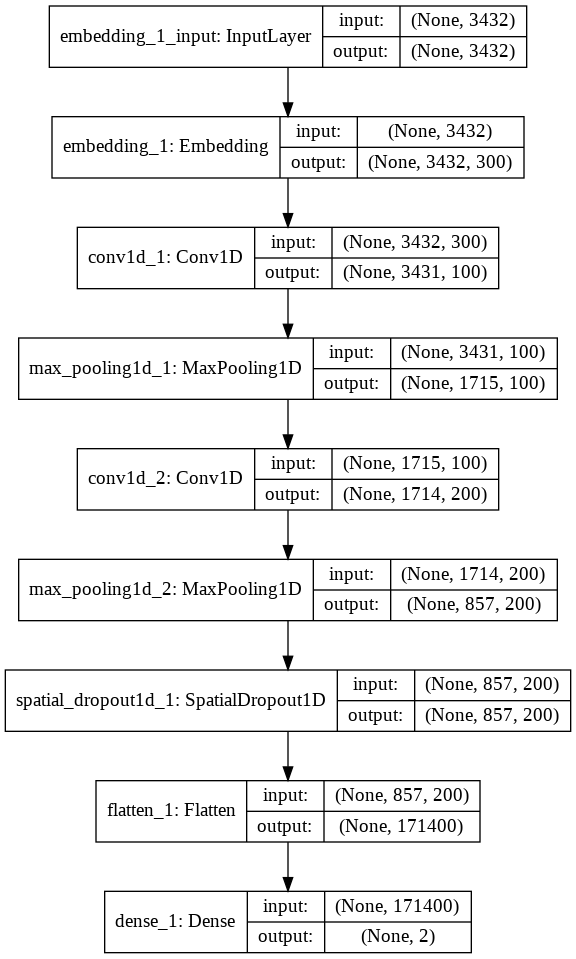

In [0]:
#plot of the model
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)